In [1]:
import rasterio
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import lil_matrix
from scipy.spatial.distance import euclidean

In [5]:
 def dem_flow_diGraph(dem_path):
     
    """
    Builds a directed graph from a LiDAR-derived DEM (TIFF)
    
    Args: 
        dem_path (str): Path to the DEM TIFF file
        connectivity (int): assign neighbors (4 for cardinal, 8 for card. + diags)
    
    Returns:
        gruple: A tuple containing:
            - graph (scipy.sparse.lil_matrix): Adjacency matrix of the graph
            - node_coords (dict): Dictionary mapping node index to (row, col) coords
            - dem_data (numpy.ndarray): the DEM data as a 2D numpy array
    """

    with rasterio.open(dem_path) as src:
        dem_data = src.read(1)
        height, width = dem_data.shape
    
    num_nodes = height*width
    graph = lil_matrix((num_nodes, num_nodes))
    node_coordinates = {}
    
    # assuming cardinal and diagonal neighbors
    neighbors = [(-1,0), (1,0), (0,1), (0,-1),
                 (-1,-1), (-1,1), (1,-1), (1,1)]

    # tracks whether a node is a pit
    isPit = np.zeros((num_nodes,),dtype=int)
    pit_count = 0
    
    for r in range(height):
        for c in range(width):
            current_node_idx = r * width + c # remember it is zero-indexed!
            node_coordinates[current_node_idx] = (r,c)

            minSlope = 0
            slopeEdge = []
            
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
    
                if 0 <= nr < height and 0 <= nc < width: # check nr, nc in bounds
                    neighbor_node_idx = nr*width + nc # index in lil_matrix

                    slope = dem_data[nr,nc] - dem_data[r,c] # negative implies downslope from center
                    if slope < minSlope:
                        minSlope = slope
                        slopeEdge = [current_node_idx, neighbor_node_idx]
            
            #after looping through neighbors of r,c
            if minSlope < 0: # you have a maximally downsloping step
                graph[current_node_idx, neighbor_node_idx] = 1 # no weights for now
            elif minSlope == 0: # you have no downslopes
                isPit[current_node_idx] = 1
                pit_count += 1

        

                    
    
                    
    print("pit count: " + str(pit_count))
    return graph, node_coordinates, dem_data, isPit

In [6]:
# r convert normal string to raw string
dem_file = "19TDJ409849.tif"

In [7]:
graph, node_coords, dem_data, pitList = dem_flow_diGraph(dem_file)

pit count: 1365355


In [15]:
diG = nx.from_scipy_sparse_array(graph, create_using=nx.DiGraph())

In [22]:
num_nodes = diG.number_of_nodes()

In [23]:
print(str(num_nodes))

2250000


In [24]:
# assign tile coordinates to each node
nx.set_node_attributes(diG, node_coords, "crds")

In [30]:
diG.nodes[2000000]["crds"] # test crds assignment

(1333, 500)

In [31]:
nx.set_node_attributes(diG, pitList, "pit")

nonPit = 0
for i in range(num_nodes):
    nonPit += diG.nodes[i]["pit"]
print(nonPit)

In [ ]:
# assign elev attribute from DEM
for i in range(num_nodes):
    diG.nodes[i]["elev"] = dem_data(diG.nodes[i]["crds"])


In [77]:
edge_num = 0
for i in range(num_nodes):
    for j in range(num_nodes):
        if diG.number_of_edges(i,j) > 0 or diG.number_of_edges(j,i) >0:
            print(str(i) + " " + str(j))
            edge_num += 1
            if edge_num > 1:
                break
    

0 1501
1 1502
2 1503
3 1504
4 1505
5 1506
6 1507
7 1508
8 1509
9 1510
10 1511
11 1512
12 1513
13 1514
14 1515
15 1516
16 1517
17 1518
18 1519
19 1520
20 1521
21 1522
22 1523
23 1524
24 1525
25 1526
26 1527
27 1528
28 1529
29 1530
30 1531
31 1532
32 1533
33 1534
34 1535
35 1536
36 1537
37 1538
38 1539
39 1540
40 1541
41 1542
42 1543
43 1544
44 1545
45 1546
46 1547
47 1548
48 1549
49 1550
50 1551
51 1552
52 1553
53 1554
54 1555
55 1556
56 1557
57 1558
58 1559
59 1560
60 1561
61 1562
62 1563
63 1564
65 1566
66 1567
67 1568
68 1569
69 1570
70 1571
71 1572
72 1573
73 1574
74 1575
75 1576
76 1577
77 1578
78 1579
79 1580
80 1581
81 1582
82 1583
83 1584
84 1585
85 1586
86 1587
87 1588
88 1589
89 1590
90 1591
91 1592
92 1593
93 1594
94 1595
95 1596
96 1597
97 1598
98 1599
99 1600
100 1601
101 1602
102 1603
103 1604
104 1605
105 1606
106 1607
107 1608
108 1609
109 1610
110 1611
111 1612
112 1613
113 1614
114 1615
115 1616
116 1617
117 1618
118 1619
119 1620
120 1621
121 1622
123 1624
124 1625
12

KeyboardInterrupt: 

In [79]:
nodeList = np.array([0,1501,1,1502,3,1504])

In [83]:
labels=nx.get_node_attributes(diG,"crds")

In [80]:
H = diG.subgraph(nodeList)

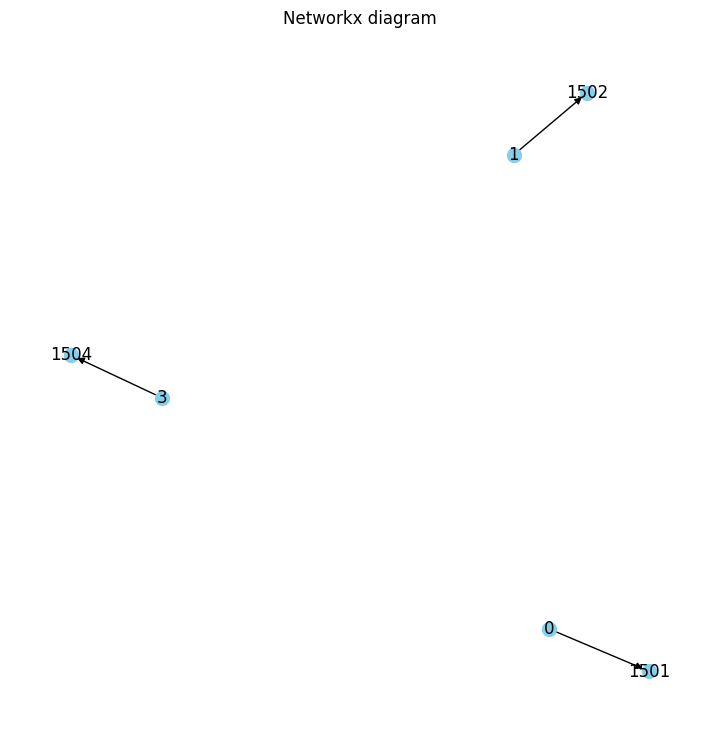

In [87]:
plt.figure(figsize=(7,7))
# define layout for nodes
pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='k', arrows=True)
plt.title("Networkx diagram")
plt.show()

In [9]:
with rasterio.open(dem_file) as src:
        dem_prac = src.read(1)
        height, width = dem_prac.shape
print(str(height) + " " + str(width))

1500 1500


In [11]:
np.count_nonzero(dem_prac)

2249984

In [13]:
%store K

Stored 'K' (DiGraph)


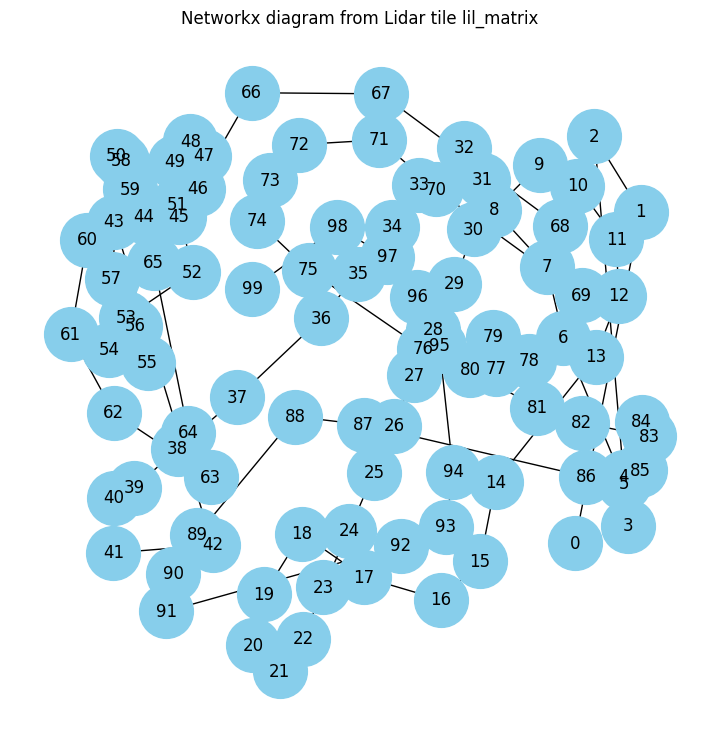

In [18]:
plt.figure(figsize=(7,7))
# define layout for nodes
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='k', arrows=False)
plt.title("Networkx diagram from Lidar tile lil_matrix")
plt.show()